In [1]:
from __future__ import print_function

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import matplotlib.pylab as plt
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [2]:
# import dataset

shuffled_df = pd.read_csv("shuffled_df.csv", index_col=0)

In [3]:
# define list of texts and list of labels

texts = shuffled_df["Body"].tolist()  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = shuffled_df["Category"].tolist()  # list of label ids

In [ ]:
# clean html tags from texts

import re

def remove_html_tags(data):
    p = re.compile(r'<.*?>')
    return p.sub('', data)

cleantexts = []

for i in range(len(texts)):
    para = str(texts[i])
    # print(para)
    # print(type(para))
    cleantext = remove_html_tags(para)
    cleantexts.append(cleantext)
    
    

In [5]:
# set up list of categories to map labels to

labels_index = {}

categories = ["ai", 
              "batterytech", 
              "blackswans", 
              "blockchain", 
              "carboneradication", 
              "cpr_articles", 
              "digitalads", 
              "digitalcurrency",
              "digitalhealth", 
              "educationtech", 
              "financialservices", 
              "internetofthings", 
              "property", 
              "sharingeconomy"]

cleanlabels = []

for name in categories:
    label_id = len(labels_index)
    labels_index[name] = label_id
    
for label in labels:
    cleanlabels.append(labels_index[label])
    

In [6]:
# Functions for F1 Recall and Precision metrics

from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))

In [7]:
# tokenize data and set up train/text data sets

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

MAX_NUM_WORDS = 2000
MAX_SEQUENCE_LENGTH = 150
VALIDATION_SPLIT = 0.2

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(cleantexts)
sequences = tokenizer.texts_to_sequences(cleantexts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

cleanlabels = to_categorical(np.asarray(cleanlabels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', cleanlabels.shape)

# split the data into a training set and a validation set (set to 0.2 here)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
cleanlabels = cleanlabels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = cleanlabels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = cleanlabels[-nb_validation_samples:]


Found 96217 unique tokens.
Shape of data tensor: (43488, 150)
Shape of label tensor: (43488, 14)


In [10]:
# prepare GloVe word embedding vector pre-processing

import os

GLOVE_DIR = "./data/glove/glove.6B/"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [11]:
# prepare embedding matrix
# setting EMBEDDING_DIM to 100. can tweak this later...

EMBEDDING_DIM = 100

num_words = min(MAX_NUM_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [12]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed

from keras.layers import Embedding

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [15]:
from keras.layers import Dense, Input
from keras.layers import Bidirectional
from keras.models import Model

# create the model

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
preds = Dense(14, activation='softmax')(l_lstm)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[f1])
print(model.summary())
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 100)          200000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_2 (Dense)              (None, 14)                2814      
Total params: 363,614
Trainable params: 163,614
Non-trainable params: 200,000
_________________________________________________________________
None
Train on 34791 samples, validate on 8697 samples
Epoch 1/10
34791/34791 [==============================] - 298s 9ms/step - loss: 1.5525 - f1: nan - val_loss: 1.1096 - val_f1: 0.5997
Epoch 2/10
34791/34791 [==============================] - 283s 8ms/step - l

In [16]:
# Final evaluation of the model
scores = model.evaluate(x_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 72.20%


In [17]:
# set up a one hot index of predicted values for our test
# data, for plotting

y_softmax = model.predict(x_val)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_val)):
    probs = y_val[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [18]:
# plot the confusion matrix

import matplotlib.pyplot as plt

# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

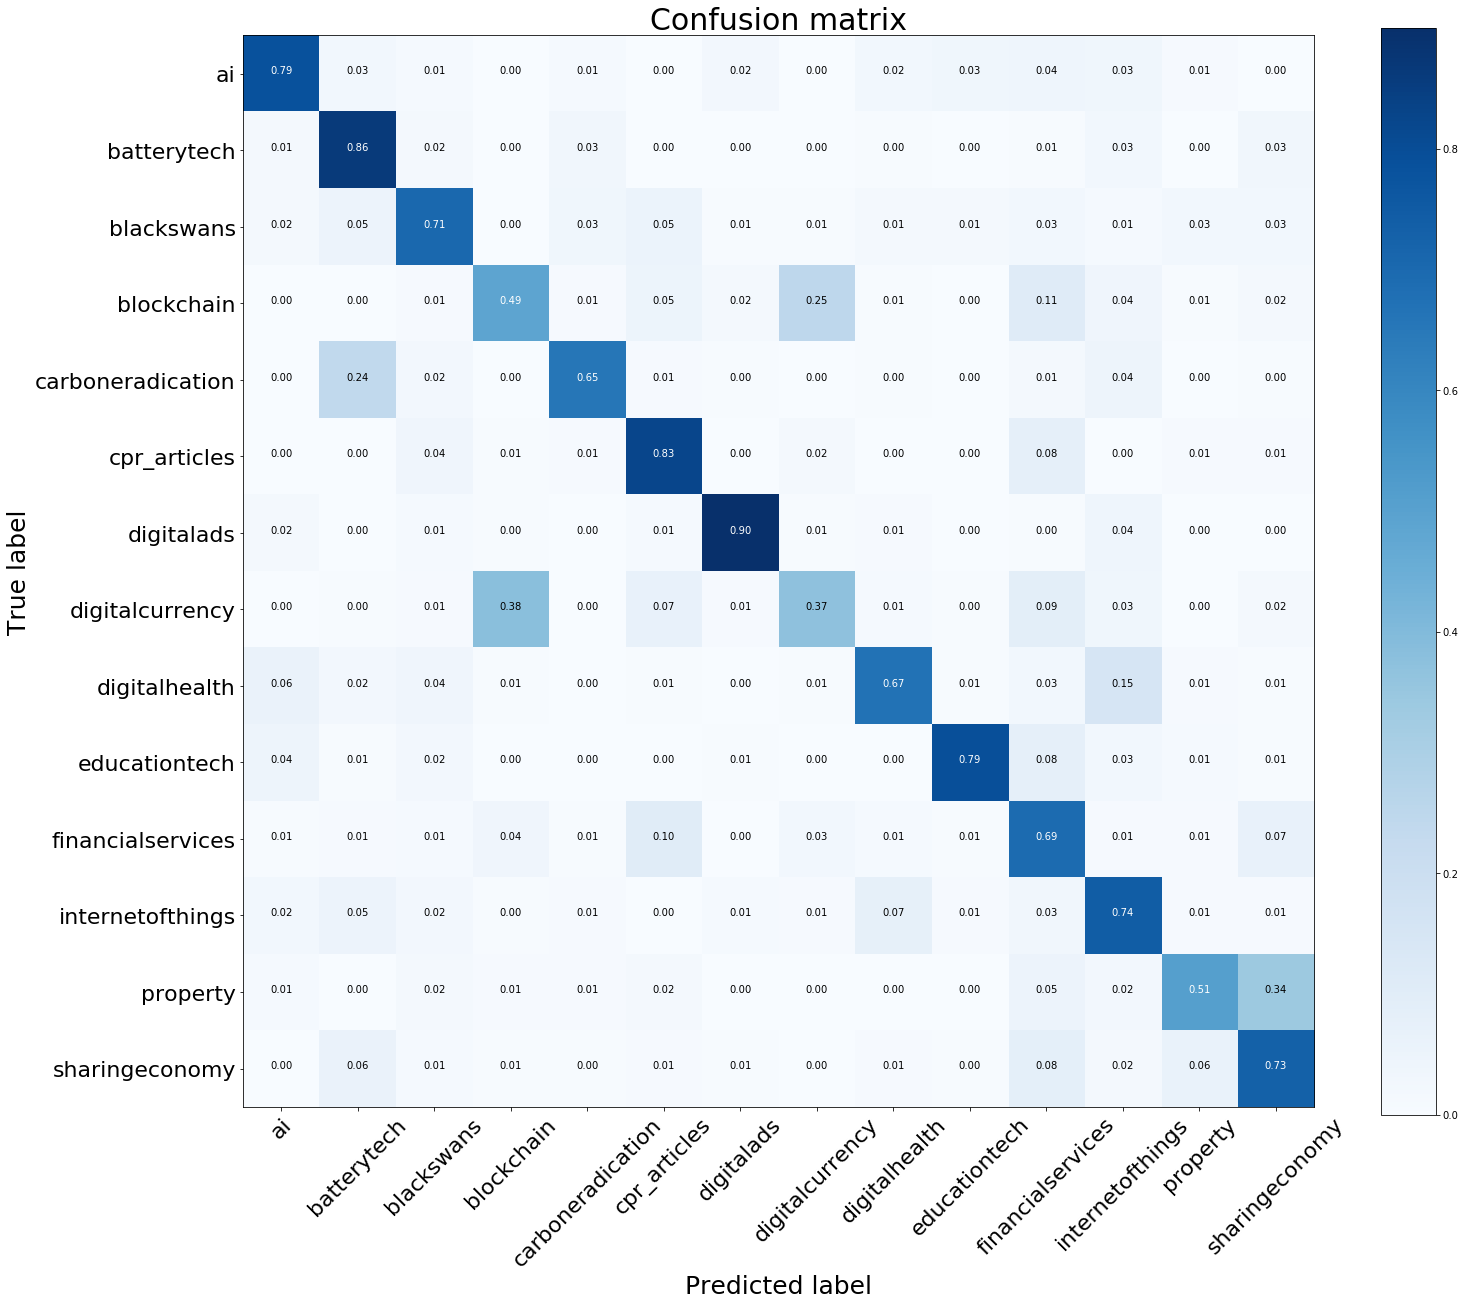

In [19]:
import itertools
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=categories, title="Confusion matrix")
plt.show()

In [42]:
# Here's how to predict a category for an individual example by tokenizing it first

number_of_text = 40000

text_to_predict = str(texts[number_of_text])
print("Text_to_predict: \n", text_to_predict)

cleantext = remove_html_tags(text_to_predict)
print("Cleaned text: \n", cleantext)

sequence = tokenizer.texts_to_sequences([cleantext])
print("Sequence: \n", sequence, "\n Sequence length: ", len(sequence), "\n")

trans_text = pad_sequences(sequence, maxlen=120)
print("Trans_text shape: ", trans_text.shape, "\n")

prediction = model.predict(np.array(trans_text))
print(prediction, "\n")

predicted_label = categories[np.argmax(prediction)]
print("Predicted Category number: ", np.argmax(prediction))
print("Predicted Category name: ", predicted_label)
print("Actual Category name: ", labels[number_of_text], "\n\n")

Text_to_predict: 
 <p>Another of China's big banks has been hit by claims of fraudulent loans, threatening to further undermine China's $29tn banking system, which is already under strain from an indebted corporate sector. Loan frauds are hitting balance sheets from larger banks, such as the Agricultural Bank of China<strong>,</strong> to smaller commercial lenders. The latest is Bank of Liuzhou where $4.9bn in fraudulent loans have been discovered, representing over 40% of the bank's total assets, a dent so large it is expected to need government intervention. This follows <a href="https://next.ft.com/content/6aa960c0-c5a5-11e5-993a-d18bf6826744">China Citic Bank</a> which has been hit by an investigation of $147m of fraud and <a href="https://next.ft.com/content/182c1b4a-c0bd-11e5-a8c6-deeeb63d6d4b">Agricultural Bank of China</a> which has become embroiled in a $578m embezzlement case. Furthermore, corruption at city commercial banks in China has increased the overall risk in the nat

In [41]:
# Here's how predict a series of texts

for i in range(10):
    number_of_text = i+40000

    text_to_predict = str(texts[number_of_text])
    #print("Text_to_predict: \n", text_to_predict)

    cleantext = remove_html_tags(text_to_predict)
    print("Body text: \n", cleantext)

    sequence = tokenizer.texts_to_sequences([cleantext])
    #print("Sequence: \n", sequence, "\n Sequence length: ", len(sequence), "\n")

    trans_text = pad_sequences(sequence, maxlen=120)
    #print("Trans_text shape: ", trans_text.shape, "\n")

    prediction = model.predict(np.array(trans_text))
    #print(prediction, "\n")

    predicted_label = categories[np.argmax(prediction)]
    print("Predicted Category number: ", np.argmax(prediction))
    print("Predicted Category name: ", predicted_label)
    #print("Actual Category name: ", categories[np.argmax(cleanlabels[i])], "\n\n")
    print("Actual Category name: ", labels[i+40000], "\n\n")

Body text: 
 Another of China's big banks has been hit by claims of fraudulent loans, threatening to further undermine China's $29tn banking system, which is already under strain from an indebted corporate sector. Loan frauds are hitting balance sheets from larger banks, such as the Agricultural Bank of China, to smaller commercial lenders. The latest is Bank of Liuzhou where $4.9bn in fraudulent loans have been discovered, representing over 40% of the bank's total assets, a dent so large it is expected to need government intervention. This follows China Citic Bank which has been hit by an investigation of $147m of fraud and Agricultural Bank of China which has become embroiled in a $578m embezzlement case. Furthermore, corruption at city commercial banks in China has increased the overall risk in the nation's banking system, says Professor Wang Chunyang, adding that he doubts "some of them will be able to cover their losses".

Predicted Category number:  5
Predicted Category name:  cp